## Fine Tuning of VGG16 for Biofuel Material Cassification

In [1]:
import lib
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras as kr
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
import itertools

%matplotlib inline

[02:56:56] Library functions loaded.


[02:56:59] Loaded custom functions.
[02:56:59] Loading regular data sets...
Found 248 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
[02:57:00] Loading augmented data sets...
Found 248 images belonging to 2 classes.
[02:57:00] Loaded existing dataset & performed data augmentation.
[02:57:00] Displaying first 1 batches of the augmented_train_set VS train_set:


C:\ProgramData\Anaconda3\envs\ICB\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


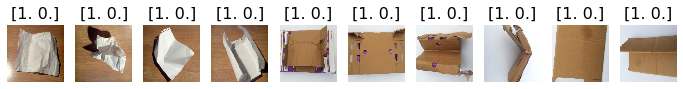

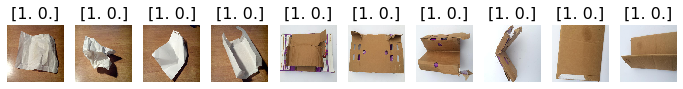

[02:57:01] Data Augmentation & Dataset loading completed!
	Time taken:  1.4014980792999268


In [2]:
# Implementation Dependant Globals
REQUIRED_DIMENSIONS = (224, 224)
TRAIN_BATCH_SIZE  = 10
VALIDATION_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10
N_AUG_VS_TEST = 1

# Import dataset
%run DataAugmentation.ipynb 

#### Fetch & Download VGG16 model

In [3]:
vgg16 = kr.applications.vgg16
vgg16_model = vgg16.VGG16(
    include_top=False, 
    weights='imagenet', 
    input_tensor=kr.layers.Input(shape=REQUIRED_DIMENSIONS+(3,))
)
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Building & Compiling

In [4]:
# Ease of Access
Model, Dropout, Flatten, Dense = kr.models.Model, kr.layers.Dropout, kr.layers.Flatten, kr.layers.Dense

# Construct the Head Model
head_model = vgg16_model.output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(512, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

# place the head model on top of the base model (this will become the actual model we will train)
model = Model(inputs=vgg16_model.input, outputs=head_model)

# Freeze all the layers
for layer in vgg16_model.layers[:]:
    layer.trainable = False

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Warmup Training

In [5]:
# Compile Module
model.compile(
    loss='binary_crossentropy',
    optimizer=kr.optimizers.RMSprop(lr=1e-4),
    metrics=['accuracy']
)

# Train the head of the module (Our Layers)
t1_history = model.fit_generator(
    train_set,
    steps_per_epoch=train_set.samples/train_set.batch_size,
    epochs=30,
    validation_data=validation_set,
    validation_steps=validation_set.samples/validation_set.batch_size,
    verbose=1,
    shuffle=True
)

Epoch 1/30
25/24 [==============================] - 34s 1s/step - loss: 3.8458 - accuracy: 0.7097 - val_loss: 1.3360 - val_accuracy: 0.8889
Epoch 2/30
25/24 [==============================] - 32s 1s/step - loss: 1.5311 - accuracy: 0.8831 - val_loss: 1.9647 - val_accuracy: 0.8403
Epoch 3/30
25/24 [==============================] - 32s 1s/step - loss: 0.8334 - accuracy: 0.9113 - val_loss: 0.8479 - val_accuracy: 0.9236
Epoch 4/30
25/24 [==============================] - 32s 1s/step - loss: 0.4421 - accuracy: 0.9637 - val_loss: 0.7710 - val_accuracy: 0.9306
Epoch 5/30
25/24 [==============================] - 32s 1s/step - loss: 0.2472 - accuracy: 0.9798 - val_loss: 1.8544 - val_accuracy: 0.8472
Epoch 6/30
25/24 [==============================] - 32s 1s/step - loss: 0.2170 - accuracy: 0.9677 - val_loss: 0.9137 - val_accuracy: 0.9236
Epoch 7/30
25/24 [==============================] - 32s 1s/step - loss: 0.0644 - accuracy: 0.9960 - val_loss: 0.9772 - val_accuracy: 0.9236
Epoch 8/30
25/24 [==

1/1 [==============================] - 17s 17s/step
              precision    recall  f1-score   support

     biomass       0.92      0.94      0.93        35
 non_biomass       0.94      0.91      0.93        35

    accuracy                           0.93        70
   macro avg       0.93      0.93      0.93        70
weighted avg       0.93      0.93      0.93        70

Normalized confusion matrix


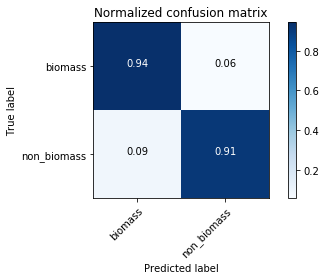

In [6]:
# Make sure everything is okay
test_set.reset()
test_set.batch_size = 70

predictions = model.predict_generator(test_set, steps=1, verbose=1)
normalised_predictions = np.argmax(predictions, axis=1)

# Print out scikit report
print(classification_report(test_set.classes, normalised_predictions, target_names=['biomass', 'non_biomass']))
# Draw confusion matrix
lib.plot_confusion_matrix(test_set.classes, normalised_predictions, ['biomass', 'non_biomass'])

#### Final Training

In [7]:
# Reset validaiton & train set generators
train_set.reset()
validation_set.reset()

# Now that the head FC layers have been trained/initialized, lets
# Unfreeze the final set of CONV layers and make them trainable
for layer in vgg16_model.layers[15:]:
	layer.trainable = True

    
# Recompile module for changes to take effect, now using SGD with very small learning rate
model.compile(
    loss="binary_crossentropy", 
    optimizer=kr.optimizers.RMSprop(lr=1e-4), 
    metrics=["accuracy"]
)    

# Train the whole module
t2_history = model.fit_generator(
    train_set,
    steps_per_epoch=train_set.samples/train_set.batch_size,
    epochs=30,
    validation_data=validation_set,
    validation_steps=validation_set.samples/validation_set.batch_size,
    verbose=1,
    shuffle=True
)

Epoch 1/30
25/24 [==============================] - 39s 2s/step - loss: 0.5919 - accuracy: 0.9556 - val_loss: 3.2057 - val_accuracy: 0.7708
Epoch 2/30
25/24 [==============================] - 38s 2s/step - loss: 1.9426 - accuracy: 0.8629 - val_loss: 1.1581 - val_accuracy: 0.9097
Epoch 3/30
25/24 [==============================] - 39s 2s/step - loss: 1.1693 - accuracy: 0.9234 - val_loss: 2.1007 - val_accuracy: 0.8472
Epoch 4/30
25/24 [==============================] - 37s 1s/step - loss: 0.7860 - accuracy: 0.9435 - val_loss: 1.8455 - val_accuracy: 0.8681
Epoch 5/30
25/24 [==============================] - 38s 2s/step - loss: 0.9974 - accuracy: 0.9274 - val_loss: 2.3560 - val_accuracy: 0.8333
Epoch 6/30
25/24 [==============================] - 38s 2s/step - loss: 1.5776 - accuracy: 0.8871 - val_loss: 1.3776 - val_accuracy: 0.9097
Epoch 7/30
25/24 [==============================] - 38s 2s/step - loss: 1.2026 - accuracy: 0.9113 - val_loss: 3.7657 - val_accuracy: 0.7639
Epoch 8/30
25/24 [==

1/1 [==============================] - 4s 4s/step
              precision    recall  f1-score   support

     biomass       0.92      0.94      0.93        35
 non_biomass       0.94      0.91      0.93        35

    accuracy                           0.93        70
   macro avg       0.93      0.93      0.93        70
weighted avg       0.93      0.93      0.93        70

Normalized confusion matrix


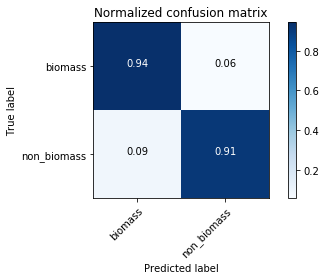

In [8]:
# Make sure everything is okay
test_set.reset()
test_set.batch_size = 70

predictions = model.predict_generator(test_set, steps=1, verbose=1)
normalised_predictions = np.argmax(predictions, axis=1)

# Print out scikit report
print(classification_report(test_set.classes, normalised_predictions, target_names=['biomass', 'non_biomass']))
# Draw confusion matrix
lib.plot_confusion_matrix(test_set.classes, normalised_predictions, ['biomass', 'non_biomass'])

#### Visualising Training History

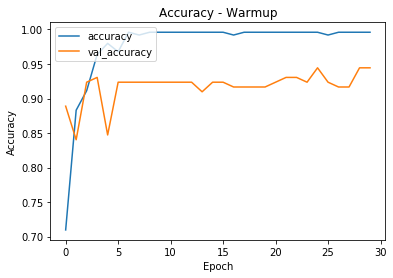

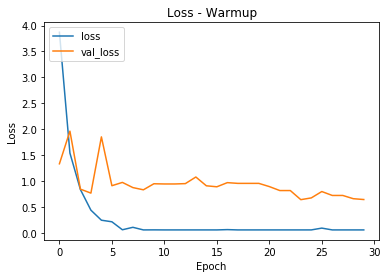

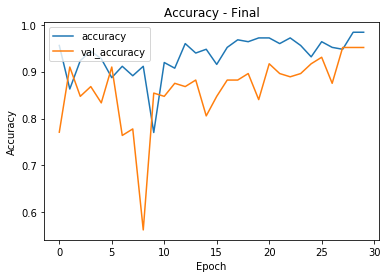

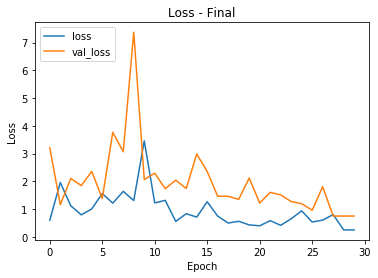

In [9]:
t1_history.plot_title = "Warmup"
t2_history.plot_title = "Final"

global_history = [t1_history, t2_history]

for history in global_history:
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title("Accuracy - " + history.plot_title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss - " + history.plot_title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [10]:
model.save('app\\trained_models\\VGG16')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: app\trained_models\VGG16\assets
